In [2]:
!pip install scipy

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# from google.colab import drive

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

#from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt_tab")
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from gensim.models import KeyedVectors
# import gensim.downloader as api
import random
import os

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
#VSCODE
train_df = pd.read_csv(r"/Users/pedrosantos/Documents 2/Text Mining/Data/train.csv")
test_df = pd.read_csv(r"/Users/pedrosantos/Documents 2/Text Mining/Data/test.csv")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df["text"], train_df["label"], test_size=0.2, stratify=train_df["label"], random_state=42)

In [6]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def full_preprocess(text):
    # ─── STEP 1: BASIC CLEANING ───
    text = re.sub(r"http\S+|www\S+", "<URL>", text)          # Replace URLs
    text = re.sub(r"@\w+", "<USER>", text)                   # Replace mentions
    text = re.sub(r"#", "", text)                            # Remove hashtag symbol
    text = re.sub(r"[^\w\s]", " ", text)                 # Remove punctuation selectively
    text = text.lower()                                      # Lowercase
    text = re.sub(r"\s+", " ", text).strip()                 # Normalize spaces

    # ─── STEP 2: TOKENIZATION ───
    tokens = nltk.word_tokenize(text)

    # ─── STEP 3: REMOVE STOPWORDS ───
    tokens = [word for word in tokens if word not in stop_words]

    # ─── STEP 4: LEMMATIZATION ───
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # ─── STEP 5: STEMMING ───
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

In [7]:
X_train_tokens = X_train.apply(full_preprocess)
X_test_tokens = X_test.apply(full_preprocess)

<hr>
<hr>

# BoW + KNN - (Also Tried TF-IDF)

In [8]:
bow = CountVectorizer()

tf_idf = TfidfVectorizer()

# teste 1
X_train_bow = bow.fit_transform(X_train_tokens.apply(lambda x: " ".join(x)))
X_test_bow = bow.transform(X_test_tokens.apply(lambda x: " ".join(x)))
# teste 2
X_train_tfidf = tf_idf.fit_transform(X_train_tokens.apply(lambda x: " ".join(x)))
X_test_tfidf = tf_idf.transform(X_test_tokens.apply(lambda x: " ".join(x)))

In [9]:
knn_values = [1, 3, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
knn_scores = []
for k in knn_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine", weights="distance")
    knn.fit(X_train_bow, y_train)
    y_pred = knn.predict(X_test_bow)
    report = classification_report(y_test, y_pred, output_dict=True)
    knn_scores.append(report["accuracy"])

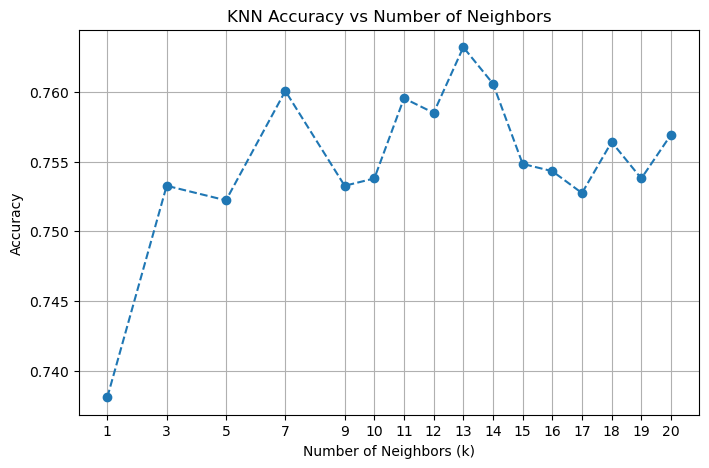

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(knn_values, knn_scores, marker='o', linestyle='--')
plt.title('KNN Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(knn_values)
plt.show()

In [11]:
best_k = 13
best_knn = KNeighborsClassifier(n_neighbors=best_k, metric="cosine", weights="distance")
best_knn.fit(X_train_bow, y_train)
y_best_pred = best_knn.predict(X_test_bow)

labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_best_pred, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.30      0.71      0.42       122
     Bullish       0.55      0.69      0.61       305
     Neutral       0.94      0.78      0.85      1482

    accuracy                           0.76      1909
   macro avg       0.60      0.73      0.63      1909
weighted avg       0.84      0.76      0.79      1909



In [27]:
param_grid_knn = {
    'n_neighbors': [13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    scoring='f1_macro',
    cv=5,
    verbose=1
)

grid.fit(X_train_bow, y_train)
print("Best parameters found: ", grid.best_params_)
print("Best score: ", grid.best_score_)
y_pred_grid = grid.predict(X_test_bow)
print(classification_report(y_test, y_pred_grid, target_names=labels.keys()))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found:  {'metric': 'cosine', 'n_neighbors': 13, 'weights': 'distance'}
Best score:  0.6114179054992614
              precision    recall  f1-score   support

     Bearish       0.71      0.30      0.42       288
     Bullish       0.69      0.55      0.61       385
     Neutral       0.78      0.94      0.85      1236

    accuracy                           0.76      1909
   macro avg       0.73      0.60      0.63      1909
weighted avg       0.75      0.76      0.74      1909



<hr>

- TF-IDF

In [12]:
knn_values = [1, 3, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
knn_scores = []
for k in knn_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine", weights="distance")
    knn.fit(X_train_tfidf, y_train)
    y_pred = knn.predict(X_test_tfidf)
    report = classification_report(y_test, y_pred, output_dict=True)
    knn_scores.append(report["accuracy"])

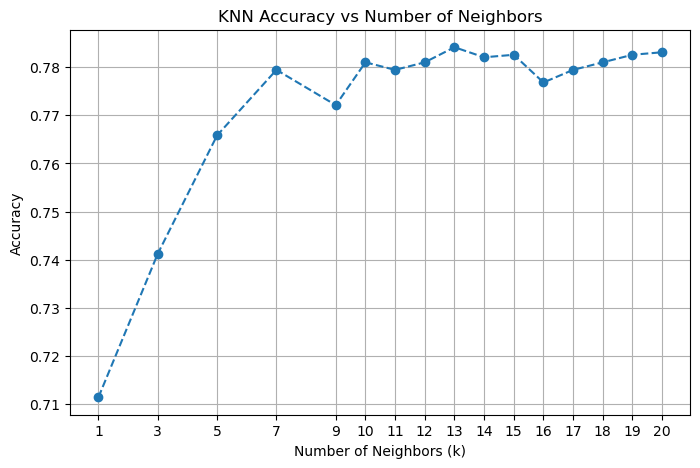

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(knn_values, knn_scores, marker='o', linestyle='--')
plt.title('KNN Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(knn_values)
plt.show()

In [14]:
best_k = 13
best_knn = KNeighborsClassifier(n_neighbors=best_k, metric="cosine", weights="distance")
best_knn.fit(X_train_tfidf, y_train)
y_best_pred = best_knn.predict(X_test_tfidf)

labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_best_pred, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.39      0.75      0.51       150
     Bullish       0.55      0.72      0.62       295
     Neutral       0.95      0.80      0.87      1464

    accuracy                           0.78      1909
   macro avg       0.63      0.76      0.67      1909
weighted avg       0.84      0.78      0.80      1909



- **INSIGHTS**: TF-IDF shows most prominent results, for same k VS BoW. No further refinemets will be made as we know that other methods will perform much better.

<hr>
<hr>
<hr>

# TF-IDF with SVM (More powerful Model)

- Severe Overfitting

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.svm import LinearSVC
# from sklearn.model_selection import GridSearchCV

# svm_pipeline = Pipeline([
#     ("tfidf", TfidfVectorizer()),
#     ("svm", LinearSVC())
# ])

# param_grid = {
#     "tfidf__ngram_range": [(1,1), (1,2), (2,2)],
#     "tfidf__max_df": [0.75, 0.85, 1.0],
#     "tfidf__min_df": [1,2],
#     "tfidf__max_features": [None],
#     "svm__C": [8,9,10,11,12],
#     "svm__class_weight": [None, "balanced"]
# }


# grid = GridSearchCV(
#     svm_pipeline,
#     param_grid=param_grid,
#     scoring="f1_macro",
#     cv=3,
#     verbose=1,
# )


# grid.fit(X_train, y_train)
# # ─── Best Model ───
# print(f"Best Parameters:\n{grid.best_params_}")
# print(f"Best Cross-Validation Accuracy: {grid.best_score_:.4f}")

# y_pred = grid.predict(X_test)
# labels = {"Bearish":0, "Bullish":1, "Neutral":2}
# print(classification_report(y_pred, y_test, target_names = labels.keys()))

Fitting 3 folds for each of 180 candidates, totalling 540 fits


/opt/anaconda3/envs/DL/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/DL/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/DL/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/DL/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/DL/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/DL/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarni

Best Parameters:
{'svm__C': 9, 'svm__class_weight': 'balanced', 'tfidf__max_df': 0.75, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation Accuracy: 0.7189
              precision    recall  f1-score   support

     Bearish       0.59      0.73      0.65       232
     Bullish       0.71      0.76      0.73       360
     Neutral       0.92      0.86      0.89      1317

    accuracy                           0.83      1909
   macro avg       0.74      0.78      0.76      1909
weighted avg       0.84      0.83      0.83      1909



In [ ]:
# # Use the best model from grid search
# best_model = grid.best_estimator_

# # Predict on training data
# y_train_pred = best_model.predict(X_train)

# # Compute metrics
# train_accuracy = accuracy_score(y_train, y_train_pred)
# train_f1_macro = f1_score(y_train, y_train_pred, average="macro")

# print(f"✅ Accuracy on Train Set: {train_accuracy:.4f}")
# print(f"✅ F1 Macro on Train Set: {train_f1_macro:.4f}")
# print("\n📊 Train Set Classification Report:")
# print(classification_report(y_train, y_train_pred, target_names=["Bearish", "Bullish", "Neutral"]))

✅ Accuracy on Train Set: 0.9999
✅ F1 Macro on Train Set: 0.9998

📊 Train Set Classification Report:
              precision    recall  f1-score   support

     Bearish       1.00      1.00      1.00      1154
     Bullish       1.00      1.00      1.00      1538
     Neutral       1.00      1.00      1.00      4942

    accuracy                           1.00      7634
   macro avg       1.00      1.00      1.00      7634
weighted avg       1.00      1.00      1.00      7634



### Revised Parameters:

In [50]:
svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,1), max_df=0.75, min_df=5)),
    ("svm", LinearSVC(C=0.1, class_weight="balanced"))
])


svm_pipeline.fit(X_train, y_train)

# ─── Predict ───
y_train_pred = svm_pipeline.predict(X_train)
y_test_pred = svm_pipeline.predict(X_test)

# ─── Train Metrics ───
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average="macro")

# ─── Test Metrics ───
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average="macro")

# ─── Report ───
print(f"📊 TRAIN SET")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Macro: {train_f1:.4f}")
print(classification_report(y_train, y_train_pred, target_names=["Bearish", "Bullish", "Neutral"]))

print(f"\n📊 TEST SET")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Macro: {test_f1:.4f}")
print(classification_report(y_test, y_test_pred, target_names=["Bearish", "Bullish", "Neutral"]))

📊 TRAIN SET
Accuracy: 0.8601
F1 Macro: 0.8101
              precision    recall  f1-score   support

     Bearish       0.76      0.71      0.74      1154
     Bullish       0.80      0.77      0.78      1538
     Neutral       0.90      0.92      0.91      4942

    accuracy                           0.86      7634
   macro avg       0.82      0.80      0.81      7634
weighted avg       0.86      0.86      0.86      7634


📊 TEST SET
Accuracy: 0.8036
F1 Macro: 0.7226
              precision    recall  f1-score   support

     Bearish       0.66      0.56      0.60       288
     Bullish       0.73      0.65      0.69       385
     Neutral       0.85      0.91      0.88      1236

    accuracy                           0.80      1909
   macro avg       0.75      0.70      0.72      1909
weighted avg       0.80      0.80      0.80      1909



<hr>
<hr>
<hr>